In [170]:
## Topic modelling - LDA - BERT Embeddings

In [171]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

sns.set_style('whitegrid')
sns.set_palette('pastel', 8)

In [172]:
!pwd

/home/ec2-user/SageMaker/tam_topic_modelling


In [173]:
file_path = 'data/EC2_India_Cases_WithTS-Latest.xlsx'
data = pd.read_excel(file_path, engine='openpyxl', skiprows=2)
data.head(5)

case_id                     customer_name  \
0  7380196011                  RBL Bank Limited   
1  7380196011                  RBL Bank Limited   
2  7380196011                  RBL Bank Limited   
3  7380321081  Edelweiss Financial Services Ltd   
4  7380321081  Edelweiss Financial Services Ltd   

                                 service case_billing_region  \
0    Elastic Compute Cloud (EC2 - Linux)                APAC   
1    Elastic Compute Cloud (EC2 - Linux)                APAC   
2    Elastic Compute Cloud (EC2 - Linux)                APAC   
3  Elastic Compute Cloud (EC2 - Windows)                APAC   
4  Elastic Compute Cloud (EC2 - Windows)                APAC   

  customer_billing_country_name comm_owner_agent_login  \
0                         INDIA                rayaans   
1                         INDIA                    NaN   
2                         INDIA                rayaans   
3                         INDIA                 shrmjj   
4                         INDIA                 shrmjj   

                                           comm_body case_creation_cal_date  \
0  Hi Team,  we have instance currently undergoin...           Sep 14, 2020   
1  Hi Team,  we have instance currently undergoin...           Sep 14, 2020   
2  {"transcript":[{"action":"TRANSCRIPT_START","d...           Sep 14, 2020   
3  Hi team,  we are not able to fetch ec2 system ...           Sep 14, 2020   
4                         Phone call: you and Amazon           Sep 14, 2020   

                           comm_subject               comm_date_utc  \
0  Chat: high cpu utilization of server  September 14, 2020 6:40:59   
1  Chat: high cpu utilization of server  September 14, 2020 7:03:26   
2                                   NaN  September 14, 2020 7:03:36   
3     Call: unable to fetch system logs  September 14, 2020 7:11:41   
4                          Inbound Call  September 14, 2020 7:14:29   

   case_severity  
0              4  
1              4  
2              4  
3              4  
4              4

In [174]:
data.sort_values(by=['case_id', 'comm_date_utc'], inplace=True)
data.reset_index(inplace=True)
data.drop(columns=['index'], inplace=True)
data.head(10)

case_id                     customer_name  \
0  7380196011                  RBL Bank Limited   
1  7380196011                  RBL Bank Limited   
2  7380196011                  RBL Bank Limited   
3  7380196011                  RBL Bank Limited   
4  7380196011                  RBL Bank Limited   
5  7380196011                  RBL Bank Limited   
6  7380196011                  RBL Bank Limited   
7  7380196011                  RBL Bank Limited   
8  7380321081  Edelweiss Financial Services Ltd   
9  7380321081  Edelweiss Financial Services Ltd   

                                 service case_billing_region  \
0    Elastic Compute Cloud (EC2 - Linux)                APAC   
1    Elastic Compute Cloud (EC2 - Linux)                APAC   
2    Elastic Compute Cloud (EC2 - Linux)                APAC   
3    Elastic Compute Cloud (EC2 - Linux)                APAC   
4    Elastic Compute Cloud (EC2 - Linux)                APAC   
5    Elastic Compute Cloud (EC2 - Linux)                APAC   
6    Elastic Compute Cloud (EC2 - Linux)                APAC   
7    Elastic Compute Cloud (EC2 - Linux)                APAC   
8  Elastic Compute Cloud (EC2 - Windows)                APAC   
9  Elastic Compute Cloud (EC2 - Windows)                APAC   

  customer_billing_country_name comm_owner_agent_login  \
0                         INDIA                rayaans   
1                         INDIA                    NaN   
2                         INDIA                rayaans   
3                         INDIA                    NaN   
4                         INDIA                rayaans   
5                         INDIA                rayaans   
6                         INDIA                arizona   
7                         INDIA                arizona   
8                         INDIA                 shrmjj   
9                         INDIA                 shrmjj   

                                           comm_body case_creation_cal_date  \
0  Hi Team,  we have instance currently undergoin...           Sep 14, 2020   
1  Hi Team,  we have instance currently undergoin...           Sep 14, 2020   
2  {"transcript":[{"action":"TRANSCRIPT_START","d...           Sep 14, 2020   
3  Hi John,  Sorry, we could not complete our dis...           Sep 14, 2020   
4  {"transcript":[{"action":"TRANSCRIPT_START","d...           Sep 14, 2020   
5  Hello Shruti,  Thank you for your time and pat...           Sep 14, 2020   
6  Hello,  We haven't heard back from you regardi...           Sep 14, 2020   
7  Please let us know if we helped resolve your i...           Sep 14, 2020   
8  Hi team,  we are not able to fetch ec2 system ...           Sep 14, 2020   
9                         Phone call: you and Amazon           Sep 14, 2020   

                                        comm_subject  \
0               Chat: high cpu utilization of server   
1               Chat: high cpu utilization of server   
2                                                NaN   
3               Chat: high cpu utilization of server   
4                                                NaN   
5  RE:[CASE 7380196011] Chat: high cpu utilizatio...   
6               Chat: high cpu utilization of server   
7               Chat: high cpu utilization of server   
8                  Call: unable to fetch system logs   
9                                       Inbound Call   

                 comm_date_utc  case_severity  
0   September 14, 2020 6:40:59              4  
1   September 14, 2020 7:03:26              4  
2   September 14, 2020 7:03:36              4  
3   September 14, 2020 7:48:52              4  
4   September 14, 2020 7:49:28              4  
5   September 14, 2020 9:42:41              4  
6  September 21, 2020 10:19:39              4  
7  September 24, 2020 12:13:02              4  
8   September 14, 2020 7:11:41              4  
9   September 14, 2020 7:14:29              4

In [175]:
first_response_index = data['case_id'].drop_duplicates(keep='first').index.values
data = data[data.index.isin(first_response_index)]
data.shape

(2608, 11)

In [176]:
data.to_csv('data/first_response_data.csv', index=False)

In [177]:
data = pd.read_csv('data/first_response_data.csv')
data.head()

case_id                       customer_name  \
0  7380196011                    RBL Bank Limited   
1  7380321081    Edelweiss Financial Services Ltd   
2  7380672281  Go Digit General Insurance Limited   
3  7380713151  Go Digit General Insurance Limited   
4  7380937061                      ALL_DEPRECATED   

                                 service case_billing_region  \
0    Elastic Compute Cloud (EC2 - Linux)                APAC   
1  Elastic Compute Cloud (EC2 - Windows)                APAC   
2    Elastic Compute Cloud (EC2 - Linux)                APAC   
3    Elastic Compute Cloud (EC2 - Linux)                APAC   
4    Elastic Compute Cloud (EC2 - Linux)                APAC   

  customer_billing_country_name comm_owner_agent_login  \
0                         INDIA                rayaans   
1                         INDIA                 shrmjj   
2                         INDIA               siljeurc   
3                         INDIA               lonesaji   
4                         INDIA                 pauyen   

                                           comm_body case_creation_cal_date  \
0  Hi Team,  we have instance currently undergoin...           Sep 14, 2020   
1  Hi team,  we are not able to fetch ec2 system ...           Sep 14, 2020   
2  Hi Raghavendra,   Just a quick recap of our ch...           Sep 14, 2020   
3  Hello Balaji,  This is Sajid from AWS Premium ...           Sep 14, 2020   
4  实例已经终止了,能恢复吗,数据能恢复吗 Instance ID(s):  i-08fdcb5...           Sep 14, 2020   

                                       comm_subject  \
0              Chat: high cpu utilization of server   
1                 Call: unable to fetch system logs   
2  RE:[CASE 7380672281] no command is not exeucting   
3   RE:[CASE 7380713151] Chat: instance went to 1/2   
4                                      实例已经终止了,能恢复吗   

                 comm_date_utc  case_severity  
0   September 14, 2020 6:40:59              4  
1   September 14, 2020 7:11:41              4  
2  September 14, 2020 10:48:40              4  
3  September 14, 2020 12:57:32              1  
4  September 14, 2020 11:54:03              3

In [178]:
!pip install textblob
!pip install spacy-langdetect
!pip install language-detector
!pip install symspellpy
!pip install sentence-transformers

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [179]:
!pip install gensim
!pip install stop-words

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [180]:
import os
import json
import pandas as pd
from tqdm import tqdm
import numpy as np
from nltk.corpus import wordnet
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords 

In [181]:
import os
import pandas as pd
import numpy as np
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import datetime
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import nltk

In [182]:
abbr_3 = [
    'ec2', 'ami', 'ebs', 'kms', 'cmk', 'url', 'web', 'oem', 'asn', 'gps', 'jre', 'isn', 'jmx', 'gdb', 'eol', 'gpt', 'mbr', 
    'isp', 'ide', 'phd', 'faq', 'gcc', 'vnc', 'udp', 'ntp', 'nfs', 'gpu', 'pid', 'lvm', 'gui', 'ecs', 'pem', 'awk', 'ecs', 'dms',
    'msg', 'pfa', 'rdp', 'pci', 'sep', 'fri', 'tue', 'feb', 'thu', 'gpl', 'sns', 'sme', 'acl', 'cmd', 'ecr', 'aug', 'mon', 'vpn', 
    'ssl', 'npm', 'vpn', 'rds', 'efs', 'dns', 'tcp', 'sql', 'ena', 'dec', 'emr', 'gmt', 'vpc', 'nat', 'acm', 'arn', 'cli', 'sdk',
    'api', 'cpu'
]

abbr_5 = ['mysql', 'testp', 'repos','posix','chmod','stdev','geoip','nslcd', 'upgra', 'nacls', 'utils','cyber','iface','glibc','inode']

abbr_4 = ['etho',
'nacl',
'inot',
'wmic',
'ntfs',
'arti', 
'vpcs',
'usef',
'usin',
'trai'
'http',
'repo',
'dhcp',
'smtp',
'rhui',
'rpms',
'cron',
'adfs',
'icmp',
'wget',
'gbps',
'mbps',
'pcre',
'wtmp',
'isnt',
'inet',
'clis',
'acls',
'linx',
'cors',
'bdev',
'psql',
'clen',
'dism',
'ssms',
'rdns',
'ssrf',
'parm',
'finy',
'libl',
'manu',
'fqdn',
'fsck',
'rool',
'ntpd',
'vapt',
'byos',
'raju',
'sftp',
'ethx',
'eips',
'sadc',
'byol',
'math']

ec2_abbr = abbr_3 + abbr_4 + abbr_5

In [183]:
#text cleaning
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
import re
import nltk
from nltk.tokenize import word_tokenize
from language_detector import detect_language
from nltk.stem import WordNetLemmatizer
import pkg_resources
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
if sym_spell.word_count:
    pass
else:
    sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    
lemmatizer = WordNetLemmatizer()

word_count = {}
    

def f_base(s):
    """
    :param s: string to be processed
    :return: processed string: see comments in the source code for more info
    """
    # normalization 1: xxxThis is a --> xxx. This is a (missing delimiter)
    s = re.sub(r'([a-z])([A-Z])', r'\1\. \2', s)  # before lower case
    # normalization 2: lower case
    s = s.lower()
    # normalization 3: "&gt", "&lt"
    s = re.sub(r'&gt|&lt', ' ', s)
    # normalization 4: letter repetition (if more than 2)
    s = re.sub(r'([a-z])\1{2,}', r'\1', s)
    # normalization 5: non-word repetition (if more than 1)
    s = re.sub(r'([\W+])\1{1,}', r'\1', s)
    # normalization 6: string * as delimiter
    s = re.sub(r'\*|\W\*|\*\W', '. ', s)
    # normalization 7: stuff in parenthesis, assumed to be less informal
    s = re.sub(r'\(.*?\)', '. ', s)
    # normalization 8: xxx[?!]. -- > xxx.
    s = re.sub(r'\W+?\.', '.', s)
    # normalization 9: [.?!] --> [.?!] xxx
    s = re.sub(r'(\.|\?|!)(\w)', r'\1 \2', s)
    # normalization 10: ' ing ', noise text
    s = re.sub(r' ing ', ' ', s)
    # normalization 11: noise text
    s = re.sub(r'product received for free[.| ]', ' ', s)
    # normalization 12: phrase repetition
    s = re.sub(r'(.{2,}?)\1{1,}', r'\1', s)

    return s.strip()


# language detection
def f_lan(s):
    """
    :param s: string to be processed
    :return: boolean (s is English)
    """

    # some reviews are actually english but biased toward french
    return detect_language(s) in {'English'}


###############################
#### word level preprocess ####
###############################

# filtering out punctuations and numbers
def f_punct(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with punct and number filter out
    """
    return [word for word in w_list if word.isalpha() or word in(ec2_abbr)]


# selecting nouns
def f_noun(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with only nouns selected
    """
    return [word for (word, pos) in nltk.pos_tag(w_list) if pos[:2] == 'NN' or word in(ec2_abbr)]


# typo correction
def f_typo(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with typo fixed by symspell. words with no match up will be dropped
    """
    w_list_fixed = []
    for word in w_list:
        if word not in ec2_abbr:
            suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=3)
            if suggestions:
                w_list_fixed.append(suggestions[0].term)
            else:
                pass
        else:
            w_list_fixed.append(word)
                # do word segmentation, deprecated for inefficiency
                # w_seg = sym_spell.word_segmentation(phrase=word)
                # w_list_fixed.extend(w_seg.corrected_string.split())
    return w_list_fixed


# stemming if doing word-wise
p_stemmer = PorterStemmer()


def f_stem(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with stemming
    """
    return [p_stemmer.stem(word) if word not in ec2_abbr else word for word in w_list]

def f_lemm(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with lemmatizing
    """
    return [lemmatizer.lemmatize(word) if word not in ec2_abbr else word for word in w_list]


# filtering out stop words
# create English stop words list

stop_words = (list(
    set(get_stop_words('en'))
))

def f_stopw(w_list):
    """
    filtering out stop words
    """
    return [word for word in w_list if word not in stop_words]

# def f_freqw(w_list):
    

def preprocess_sent(rw):
    """
    Get sentence level preprocessed data from raw review texts
    :param rw: review to be processed
    :return: sentence level pre-processed review
    """
    s = f_base(rw)
    if not f_lan(s):
        return None
    return s

def preprocess_word(s):
    """
    Get word level preprocessed data from preprocessed sentences
    including: remove punctuation, select noun, fix typo, stem, stop_words
    :param s: sentence to be processed
    :return: word level pre-processed review
    """
    if not s:
        return None
    w_list = word_tokenize(s)
    w_list = f_punct(w_list)
    w_list = f_noun(w_list)
#     w_list = f_typo(w_list)
    w_list = f_lemm(w_list)
    w_list = f_stopw(w_list)
#     word_count = word_counter(w_list)
    

    return w_list


In [184]:
### Modelling

In [185]:
import keras
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
import warnings

In [186]:
class Autoencoder:
    """
    Autoencoder for learning latent space representation
    architecture simplified for only one hidden layer
    """

    def __init__(self, latent_dim=32, activation='relu', epochs=200, batch_size=128):
        self.latent_dim = latent_dim
        self.activation = activation
        self.epochs = epochs
        self.batch_size = batch_size
        self.autoencoder = None
        self.encoder = None
        self.decoder = None
        self.his = None

    def _compile(self, input_dim):
        """
        compile the computational graph
        """
        input_vec = Input(shape=(input_dim,))
        encoded = Dense(self.latent_dim, activation=self.activation)(input_vec)
        decoded = Dense(input_dim, activation=self.activation)(encoded)
        self.autoencoder = Model(input_vec, decoded)
        self.encoder = Model(input_vec, encoded)
        encoded_input = Input(shape=(self.latent_dim,))
        decoder_layer = self.autoencoder.layers[-1]
        self.decoder = Model(encoded_input, self.autoencoder.layers[-1](encoded_input))
        self.autoencoder.compile(optimizer='adam', loss=keras.losses.mean_squared_error)

    def fit(self, X):
        if not self.autoencoder:
            self._compile(X.shape[1])
        X_train, X_test = train_test_split(X)
        self.his = self.autoencoder.fit(X_train, X_train,
                                        epochs=200,
                                        batch_size=128,
                                        shuffle=True,
                                        validation_data=(X_test, X_test), verbose=0)

In [187]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim import corpora
import gensim
import numpy as np
#from Autoencoder import *
#from preprocess import *
from datetime import datetime
from collections import Counter

word_to_remove = ['jan', 'feb', 'mar', 'march', 'april', 'may', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec',
'need', 'help', 'httpd', 'html', 'goibo', 'ist', 'question', 'customer', 'hey']

def word_counter(token_lists):
    word_count = {}
    for w_list in token_lists:
        for w in w_list:
            if w in word_count.keys():
                word_count[w] += 1
            else:
                word_count[w] = 1
    return word_count


def preprocess(docs, samp_size=None):
    """
    Preprocess the data
    """
    if not samp_size:
        samp_size = 100

    print('Preprocessing raw texts ...')
    n_docs = len(docs)
    sentences = []  # sentence level preprocessed
    token_lists = []  # word level preprocessed
    idx_in = []  # index of sample selected
    #     samp = list(range(100))
    samp = np.random.choice(n_docs, samp_size)
    for i, idx in enumerate(samp):
        sentence = preprocess_sent(docs[idx])
        token_list = preprocess_word(sentence)
        if token_list != None:
            if len(token_list) > 0:   
                idx_in.append(idx)
                sentences.append(sentence)
                token_lists.append(token_list)
        print('{} %'.format(str(np.round((i + 1) / len(samp) * 100, 2))), end='\r')
    f_sentences = []  # sentence level preprocessed
    f_token_lists = []  # word level preprocessed
    f_idx_in = []  # index of sample selected
    word_count = word_counter(token_lists)
    most_freq_words = list(dict(Counter(word_count).most_common(100)).keys())
    for s, tl, idx in zip(sentences, token_lists, idx_in):
        token_list = [w for w in tl if w not in most_freq_words and w not in word_to_remove and len(w) > 2]
        if len(token_list) > 0:
            f_idx_in.append(idx)
            f_sentences.append(sentence)
            f_token_lists.append(token_list)
    print('Preprocessing raw texts. Done!')
    return f_sentences, f_token_lists, f_idx_in, word_count


# define model object
class Topic_Model:
    def __init__(self, k=15, method='TFIDF'):
        """
        :param k: number of topics
        :param method: method chosen for the topic model
        """
        if method not in {'TFIDF', 'LDA', 'BERT', 'LDA_BERT'}:
            raise Exception('Invalid method!')
        self.k = k
        self.dictionary = None
        self.corpus = None
        #         self.stopwords = None
        self.cluster_model = None
        self.ldamodel = None
        self.vec = {}
        self.gamma = 15  # parameter for reletive importance of lda
        self.method = method
        self.AE = None
        self.id = method + '_' + datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

    def vectorize(self, sentences, token_lists, method=None):
        """
        Get vecotr representations from selected methods
        """
        # Default method
        if method is None:
            method = self.method

        # turn tokenized documents into a id <-> term dictionary
        self.dictionary = corpora.Dictionary(token_lists)
        # convert tokenized documents into a document-term matrix
        self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

        if method == 'TFIDF':
            print('Getting vector representations for TF-IDF ...')
            tfidf = TfidfVectorizer()
            vec = tfidf.fit_transform(sentences)
            print('Getting vector representations for TF-IDF. Done!')
            return vec

        elif method == 'LDA':
            print('Getting vector representations for LDA ...')
            if not self.ldamodel:
                self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary,
                                                                passes=20)

            def get_vec_lda(model, corpus, k):
                """
                Get the LDA vector representation (probabilistic topic assignments for all documents)
                :return: vec_lda with dimension: (n_doc * n_topic)
                """
                n_doc = len(corpus)
                vec_lda = np.zeros((n_doc, k))
                for i in range(n_doc):
                    # get the distribution for the i-th document in corpus
                    for topic, prob in model.get_document_topics(corpus[i]):
                        vec_lda[i, topic] = prob

                return vec_lda

            vec = get_vec_lda(self.ldamodel, self.corpus, self.k)
            print('Getting vector representations for LDA. Done!')
            return vec

        elif method == 'BERT':

            print('Getting vector representations for BERT ...')
            from sentence_transformers import SentenceTransformer
            model = SentenceTransformer('bert-base-nli-max-tokens')
            vec = np.array(model.encode(sentences, show_progress_bar=True))
            print('Getting vector representations for BERT. Done!')
            return vec

             
        elif method == 'LDA_BERT':
        #else:
            vec_lda = self.vectorize(sentences, token_lists, method='LDA')
            vec_bert = self.vectorize(sentences, token_lists, method='BERT')
            vec_ldabert = np.c_[vec_lda * self.gamma, vec_bert]
            self.vec['LDA_BERT_FULL'] = vec_ldabert
            if not self.AE:
                self.AE = Autoencoder()
                print('Fitting Autoencoder ...')
                self.AE.fit(vec_ldabert)
                print('Fitting Autoencoder Done!')
            vec = self.AE.encoder.predict(vec_ldabert)
            return vec

    def fit(self, sentences, token_lists, method=None, m_clustering=None):
        """
        Fit the topic model for selected method given the preprocessed data
        :docs: list of documents, each doc is preprocessed as tokens
        :return:
        """
        # Default method
        if method is None:
            method = self.method
        # Default clustering method
        if m_clustering is None:
            m_clustering = KMeans

        # turn tokenized documents into a id <-> term dictionary
        if not self.dictionary:
            self.dictionary = corpora.Dictionary(token_lists)
            # convert tokenized documents into a document-term matrix
            self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

        ####################################################
        #### Getting ldamodel or vector representations ####
        ####################################################

        if method == 'LDA':
            if not self.ldamodel:
                print('Fitting LDA ...')
                self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary,
                                                                passes=20)
                print('Fitting LDA Done!')
        else:
            print('Clustering embeddings ...')
            self.cluster_model = m_clustering(self.k)
            self.vec[method] = self.vectorize(sentences, token_lists, method)
            self.cluster_model.fit(self.vec[method])
            print('Clustering embeddings. Done!')

    def predict(self, sentences, token_lists, out_of_sample=None):
        """
        Predict topics for new_documents
        """
        # Default as False
        out_of_sample = out_of_sample is not None

        if out_of_sample:
            corpus = [self.dictionary.doc2bow(text) for text in token_lists]
            if self.method != 'LDA':
                vec = self.vectorize(sentences, token_lists)
                print(vec)
        else:
            corpus = self.corpus
            vec = self.vec.get(self.method, None)

        if self.method == "LDA":
            lbs = np.array(list(map(lambda x: sorted(self.ldamodel.get_document_topics(x),
                                                     key=lambda x: x[1], reverse=True)[0][0],
                                    corpus)))
        else:
            lbs = self.cluster_model.predict(vec)
        return lbs

In [188]:
!pip install umap-learn
!pip install wordcloud

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [202]:
from collections import Counter
from sklearn.metrics import silhouette_score
import umap
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.models.coherencemodel import CoherenceModel
import numpy as np
import os


def get_topic_words(token_lists, labels, k=None):
    """
    get top words within each topic from clustering results
    """
    if k is None:
        k = len(np.unique(labels))
    topics = ['' for _ in range(k)]
    for i, c in enumerate(token_lists):
        topics[labels[i]] += (' ' + ' '.join(c))
    word_counts = list(map(lambda x: Counter(x.split()).items(), topics))
    # get sorted word counts
    word_counts = list(map(lambda x: sorted(x, key=lambda x: x[1], reverse=True), word_counts))
    # get topics
    topics = list(map(lambda x: list(map(lambda x: x[0], x[:10])), word_counts))
    topics = [t for t in topics if len(t) > 0]
    return topics

def get_coherence(model, token_lists, measure='c_v'):
    """
    Get model coherence from gensim.models.coherencemodel
    :param model: Topic_Model object
    :param token_lists: token lists of docs
    :param topics: topics as top words
    :param measure: coherence metrics
    :return: coherence score
    """
    if model.method == 'LDA':
        cm = CoherenceModel(model=model.ldamodel, texts=token_lists, corpus=model.corpus, dictionary=model.dictionary,
                            coherence=measure)
    else:
        topics = get_topic_words(token_lists, model.cluster_model.labels_)
        print(topics)
        cm = CoherenceModel(topics=topics, texts=token_lists, corpus=model.corpus, dictionary=model.dictionary,
                            coherence=measure)
    return cm.get_coherence()

def get_silhouette(model):
    """
    Get silhouette score from model
    :param model: Topic_Model object
    :return: silhouette score
    """
    if model.method == 'LDA':
        return
    lbs = model.cluster_model.labels_
    vec = model.vec[model.method]
    return silhouette_score(vec, lbs)

def plot_proj(embedding, lbs):
    """
    Plot UMAP embeddings
    :param embedding: UMAP (or other) embeddings
    :param lbs: labels
    """
    n = len(embedding)
    counter = Counter(lbs)
    for i in range(len(np.unique(lbs))):
        plt.plot(embedding[:, 0][lbs == i], embedding[:, 1][lbs == i], '.', alpha=0.5,
                 label='cluster {}: {:.2f}%'.format(i, counter[i] / n * 100))
    plt.legend(loc = 'best')
    plt.grid(color ='grey', linestyle='-',linewidth = 0.25)


def visualize(model):
    """
    Visualize the result for the topic model by 2D embedding (UMAP)
    :param model: Topic_Model object
    """
    if model.method == 'LDA':
        return
    reducer = umap.UMAP()
    print('Calculating UMAP projection ...')
    vec_umap = reducer.fit_transform(model.vec[model.method])
    print('Calculating UMAP projection. Done!')
    plot_proj(vec_umap, model.cluster_model.labels_)
    dr = 'model/{}/{}'.format(model.method, model.id)
    if not os.path.exists(dr):
        os.makedirs(dr)
    plt.savefig('model/working/2D_vis')

def get_wordcloud(model, token_lists, topic):
    """
    Get word cloud of each topic from fitted model
    :param model: Topic_Model object
    :param sentences: preprocessed sentences from docs
    """
    if model.method == 'LDA':
        return
    print('Getting wordcloud for topic {} ...'.format(topic))
    lbs = model.cluster_model.labels_
#     tokens = []
#     for i, j in zip(lbs, range(0, len(lbs))):
#         print(i)
#         if i == topic:
#             print(token_lists[j])
#             tokens.append(token_lists[j])
#             break
        
    tokens = ' '.join([' '.join(_) for _ in np.array(token_lists)[lbs == topic]])
#     print(np.array(token_lists)[lbs == topic])
    if len(tokens) > 0:
        wordcloud = WordCloud(width=800, height=560,
                              background_color='white', collocations=False,
                              min_font_size=10).generate(tokens)


        # plot the WordCloud image
        plt.figure(figsize=(8, 5.6), facecolor=None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad=0)
        dr = 'model/working/{}/{}'.format(model.method, model.id)
        if not os.path.exists(dr):
            os.makedirs(dr)
        plt.savefig('model/working' + '/Topic' + str(topic) + '_wordcloud')
        print('Getting wordcloud for topic {}. Done!'.format(topic))
        plt.pause(0.1)

In [190]:
data = data.dropna()
data.reset_index(inplace=True)

In [191]:
### topics = 15

In [192]:
method = "LDA_BERT"
samp_size = data.shape[0]
ntopic = 15
docs = data['comm_body']
sentences, token_lists, idx_in, word_count = preprocess(docs, samp_size=samp_size)

Preprocessing raw texts ...
Preprocessing raw texts. Done!


In [193]:
# Counter(word_count).most_common(150) #['ec2', 'server', 'volume', 'ami', 'log', 'ip', 'ebs', 'host', 'security', 'production' ]

In [194]:
# Define the topic model object
# tm = Topic_Model(k = 10), method = TFIDF)
tm = Topic_Model(k = ntopic, method = method)
# Fit the topic model by chosen method
tm.fit(sentences, token_lists)

Clustering embeddings ...
Getting vector representations for LDA ...
Getting vector representations for LDA. Done!
Getting vector representations for BERT ...


Batches:   0%|          | 0/52 [00:00<?, ?it/s]

Getting vector representations for BERT. Done!
Fitting Autoencoder ...
Fitting Autoencoder Done!
Clustering embeddings. Done!


In [195]:
import pickle
with open("model/working/{}.file".format(tm.id), "wb") as f:
    pickle.dump(tm, f, pickle.HIGHEST_PROTOCOL)

In [196]:
# tm = pickle.load(open("model/working/LDA_BERT_2021_09_13_13_42_24.file", "rb"))

In [197]:
print('Coherence:', get_coherence(tm, token_lists, 'c_v'))
print('Silhouette Score:', get_silhouette(tm))

[['machine', 'snapshot', 'launch', 'password', 'key', 'credential', 'port', 'com', 'template', 'tool'], ['ssh', 'spike', 'memory', 'policy', 'option', 'key', 'hardware', 'agent', 'usage', 'password'], ['health', 'reboot', 'retirement', 'option', 'hardware', 'maintenance', 'notification', 'search', 'token', 'icmp'], ['interface', 'tag', 'dns', 'traffic', 'manager', 'internet', 'cli', 'com', 'ubuntu', 'release'], ['limit', 'document', 'stack', 'product', 'number', 'disk', 'driver', 'availability', 'image', 'code'], ['api', 'driver', 'load', 'resource', 'problem', 'com', 'thing', 'priority', 'ena', 'update'], ['agent', 'port', 'ssm', 'reachability', 'manager', 'cloudwatch', 'rdp', 'telnet', 'permission', 'strace'], ['repository', 'rule', 'yum', 'limit', 'cent', 'start', 'problem', 'stop', 'mqm', 'default'], ['sql', 'client', 'spike', 'watch', 'cluster', 'desktop', 'node', 'database', 'abuse', 'rdp'], ['ena', 'device', 'kernel', 'feature', 'month', 'architecture', 'screenshot', 'block', 'p

Calculating UMAP projection ...
Calculating UMAP projection. Done!


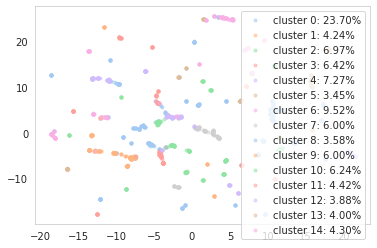

In [198]:
# visualize and save img
visualize(tm)

Getting wordcloud for topic 0 ...
Getting wordcloud for topic 0. Done!


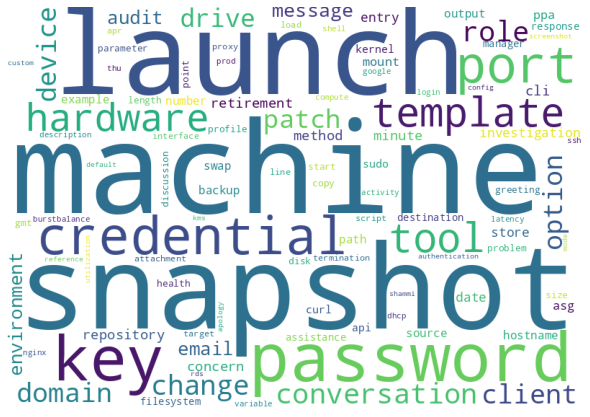

Getting wordcloud for topic 1 ...
Getting wordcloud for topic 1. Done!


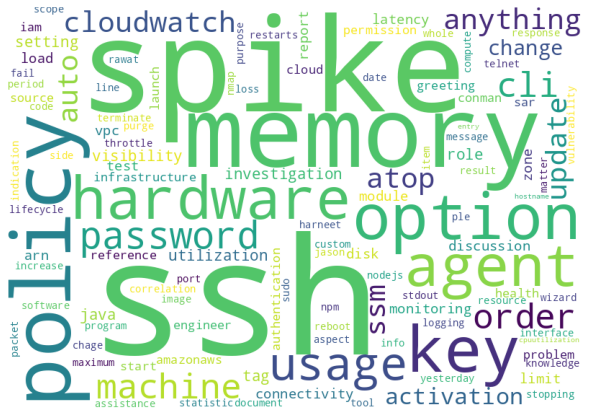

Getting wordcloud for topic 2 ...
Getting wordcloud for topic 2. Done!


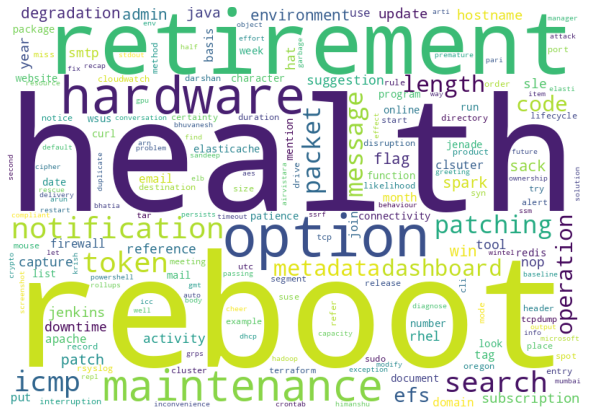

Getting wordcloud for topic 3 ...
Getting wordcloud for topic 3. Done!


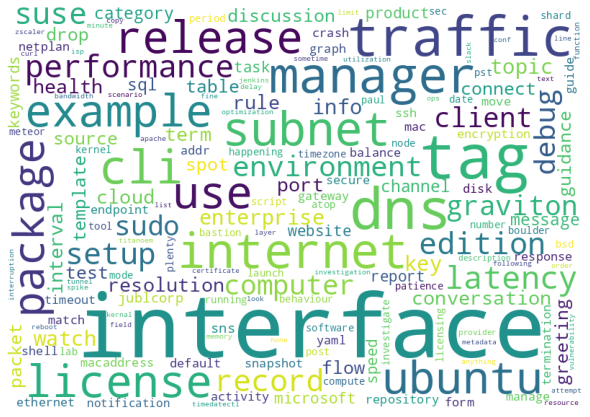

Getting wordcloud for topic 4 ...
Getting wordcloud for topic 4. Done!


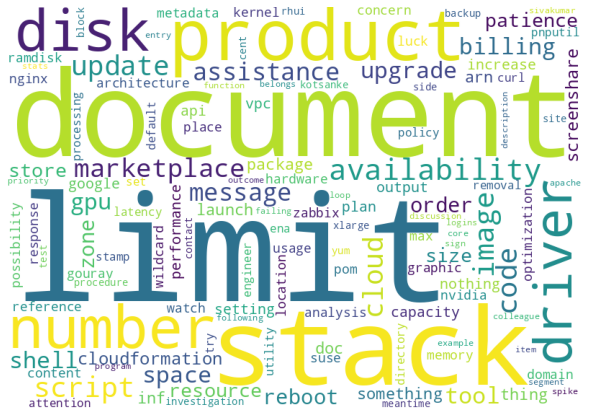

Getting wordcloud for topic 5 ...
Getting wordcloud for topic 5. Done!


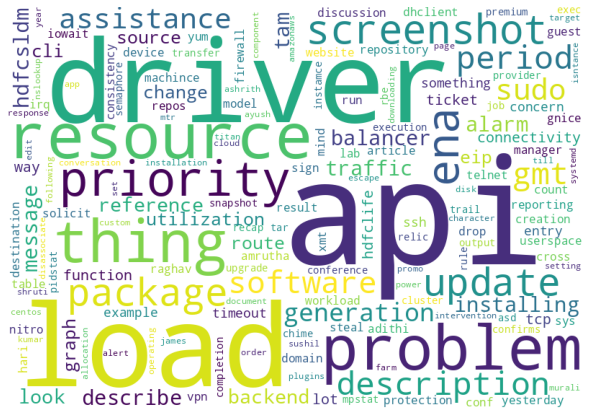

Getting wordcloud for topic 6 ...
Getting wordcloud for topic 6. Done!


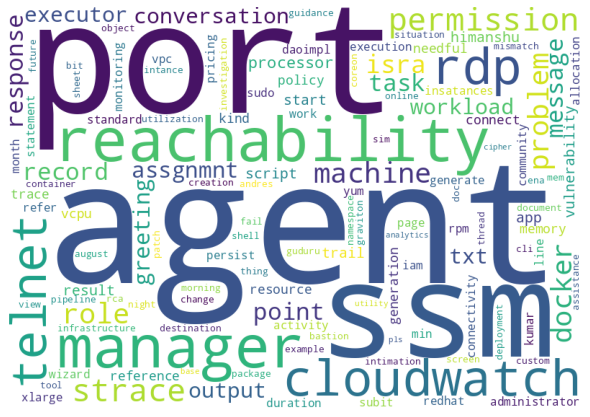

Getting wordcloud for topic 7 ...
Getting wordcloud for topic 7. Done!


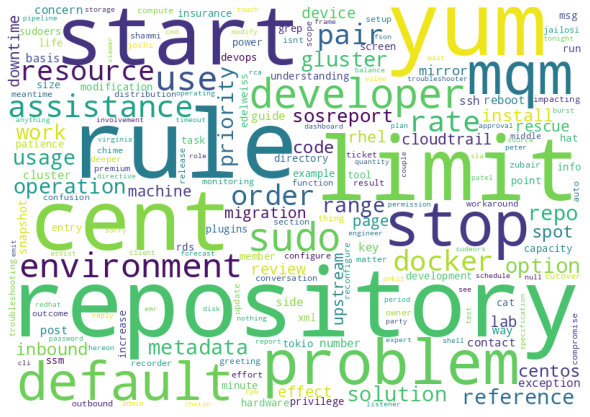

Getting wordcloud for topic 8 ...
Getting wordcloud for topic 8. Done!


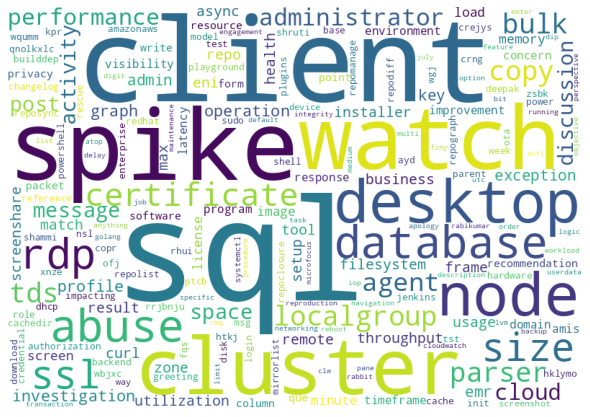

Getting wordcloud for topic 9 ...
Getting wordcloud for topic 9. Done!


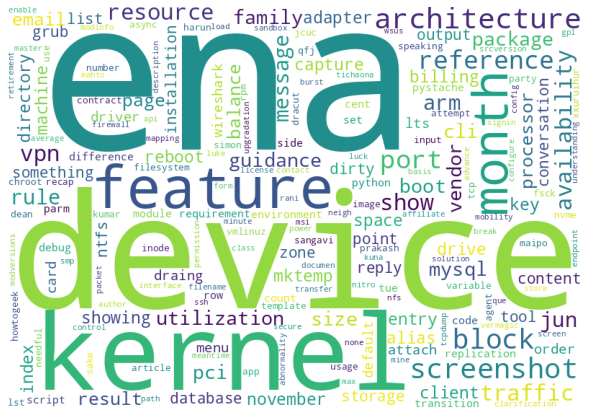

Getting wordcloud for topic 10 ...
Getting wordcloud for topic 10. Done!


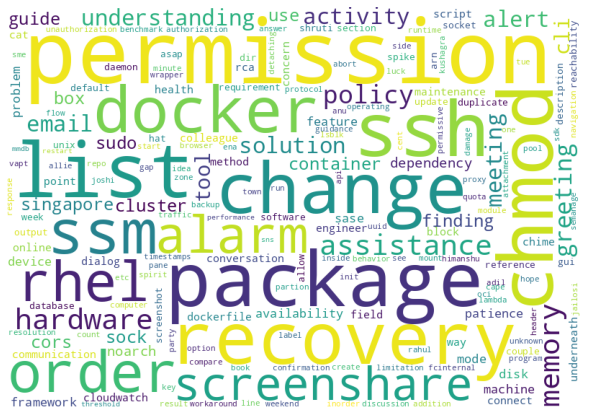

Getting wordcloud for topic 11 ...
Getting wordcloud for topic 11. Done!


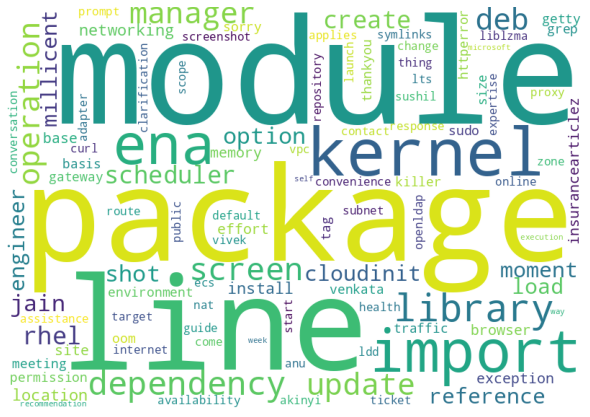

Getting wordcloud for topic 12 ...
Getting wordcloud for topic 12. Done!


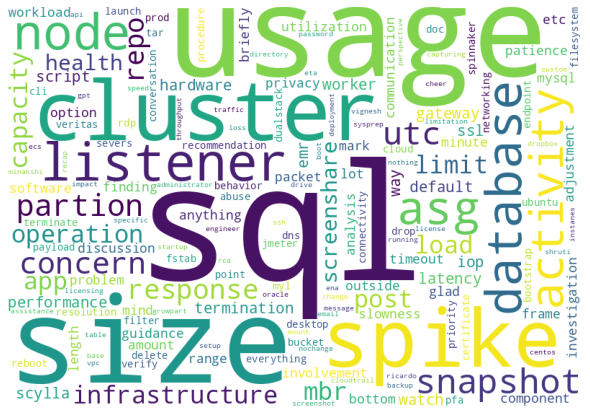

Getting wordcloud for topic 13 ...
Getting wordcloud for topic 13. Done!


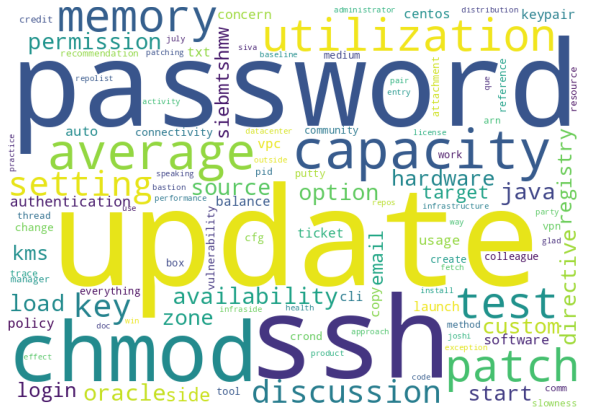

Getting wordcloud for topic 14 ...
Getting wordcloud for topic 14. Done!


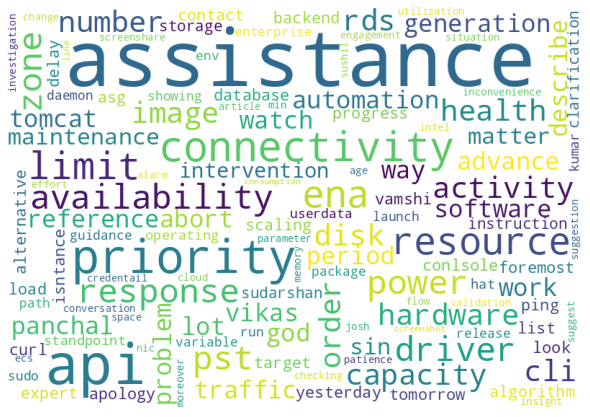

In [203]:
for i in range(tm.k):
    get_wordcloud(tm, token_lists, i)

In [200]:
result = tm.predict(sentences, token_lists)

In [201]:
Counter(result)

Counter({0: 391,
         8: 59,
         1: 70,
         9: 99,
         6: 157,
         4: 120,
         10: 103,
         13: 66,
         11: 73,
         14: 71,
         7: 99,
         12: 64,
         3: 106,
         2: 115,
         5: 57})

In [181]:
## Topic = 10

In [176]:
# method = "LDA_BERT"
# samp_size = data.shape[0]
# ntopic = 10
# docs = data['comm_body']
# sentences, token_lists, idx_in = preprocess(docs, samp_size=samp_size)
# # Define the topic model object
# # tm = Topic_Model(k = 10), method = TFIDF)
# tm = Topic_Model(k = ntopic, method = method)
# # Fit the topic model by chosen method
# tm.fit(sentences, token_lists)

In [177]:
# import pickle
# with open("model/working/{}.file".format(tm.id), "wb") as f:
#     pickle.dump(tm, f, pickle.HIGHEST_PROTOCOL)

In [178]:
# print('Coherence:', get_coherence(tm, token_lists, 'c_v'))
# print('Silhouette Score:', get_silhouette(tm))

In [179]:
# visualize and save img
# visualize(tm)

In [180]:
# for i in range(tm.k):
#     get_wordcloud(tm, token_lists, i)

In [ ]:
# Using TFIDF

In [182]:
method = "TFIDF"
samp_size = data.shape[0]
ntopic = 15
docs = data['comm_body']
sentences, token_lists, idx_in = preprocess(docs, samp_size=samp_size)
# Define the topic model object
# tm = Topic_Model(k = 10), method = TFIDF)
tm = Topic_Model(k = ntopic, method = method)
# Fit the topic model by chosen method
tm.fit(sentences, token_lists)

Preprocessing raw texts ...
Preprocessing raw texts. Done!
Clustering embeddings ...
Getting vector representations for TF-IDF ...
Getting vector representations for TF-IDF. Done!
Clustering embeddings. Done!


In [183]:
import pickle
with open("model/working/{}.file".format(tm.id), "wb") as f:
    pickle.dump(tm, f, pickle.HIGHEST_PROTOCOL)

In [184]:
print('Coherence:', get_coherence(tm, token_lists, 'c_v'))
print('Silhouette Score:', get_silhouette(tm))

[['password', 'activation', 'production', 'administrator', 'environment', 'sql', 'option', 'screen', 'role', 'driver'], ['size', 'query', 'concern', 'question', 'partion', 'script', 'screenshare', 'conversation', 'oracle', 'discussion'], ['nginx', 'image', 'need', 'production', 'default', 'location', 'auto', 'spot', 'ngx', 'marketplace'], ['reachability', 'health', 'machine', 'production', 'alarm', 'pls', 'morning', 'trail', 'assist', 'need'], ['com', 'client', 'reboot', 'goibo', 'sql', 'need', 'production', 'pid', 'dns', 'dec'], ['audit', 'family', 'resource', 'reference', 'ena', 'xlarge', 'optimization', 'filesystem', 'ok', 'init'], ['disk', 'space', 'drive', 'c', 'utilization', 'code', 'troubleshoots', 'persist', 'recomendation', 'optimization'], ['key', 'size', 'permission', 'limit', 'disk', 'api', 'mount', 'line', 'number', 'policy'], ['agent', 'cloudwatch', 'ssm', 'watch', 'installation', 'machine', 'sudo', 'py', 'dependency', 'setup'], ['chmod', 'line', 'role', 'cli', 'credentia

Calculating UMAP projection ...
Calculating UMAP projection. Done!


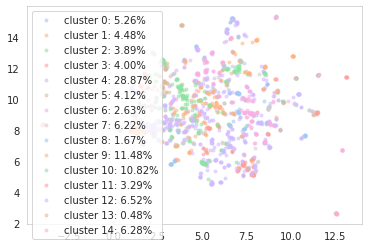

In [185]:
# visualize and save img
visualize(tm)

Getting wordcloud for topic 0 ...
Getting wordcloud for topic 0. Done!
Getting wordcloud for topic 1 ...
Getting wordcloud for topic 1. Done!
Getting wordcloud for topic 2 ...
Getting wordcloud for topic 2. Done!
Getting wordcloud for topic 3 ...
Getting wordcloud for topic 3. Done!
Getting wordcloud for topic 4 ...
Getting wordcloud for topic 4. Done!
Getting wordcloud for topic 5 ...
Getting wordcloud for topic 5. Done!
Getting wordcloud for topic 6 ...
Getting wordcloud for topic 6. Done!
Getting wordcloud for topic 7 ...
Getting wordcloud for topic 7. Done!
Getting wordcloud for topic 8 ...
Getting wordcloud for topic 8. Done!
Getting wordcloud for topic 9 ...
Getting wordcloud for topic 9. Done!
Getting wordcloud for topic 10 ...
Getting wordcloud for topic 10. Done!
Getting wordcloud for topic 11 ...
Getting wordcloud for topic 11. Done!
Getting wordcloud for topic 12 ...
Getting wordcloud for topic 12. Done!
Getting wordcloud for topic 13 ...
Getting wordcloud for topic 13. Done

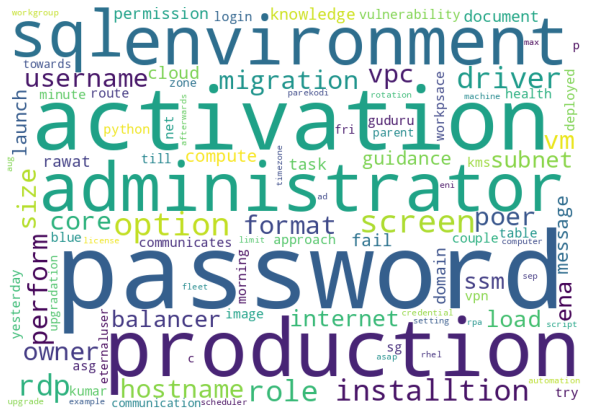

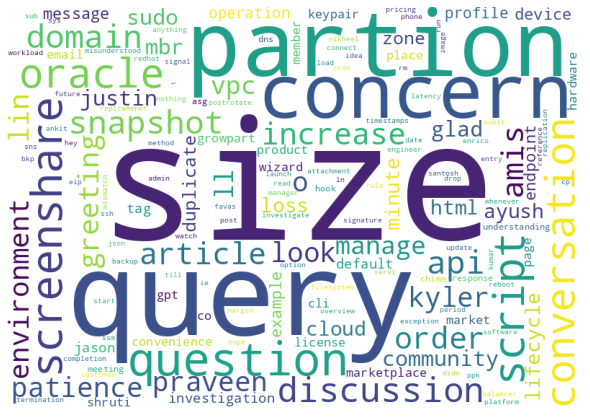

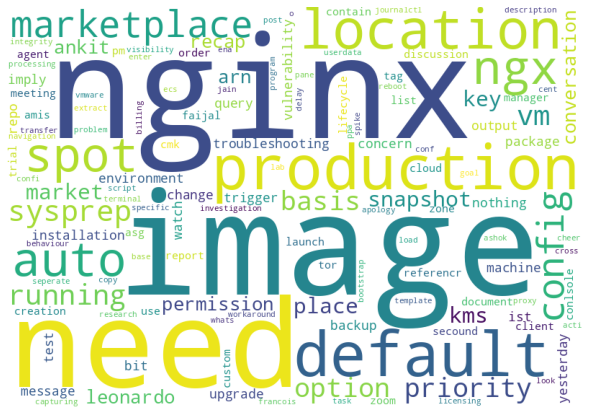

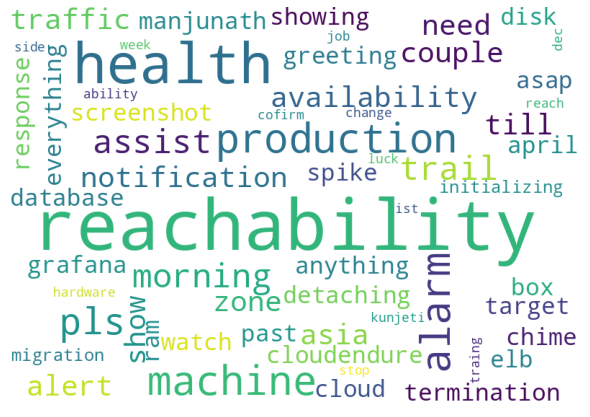

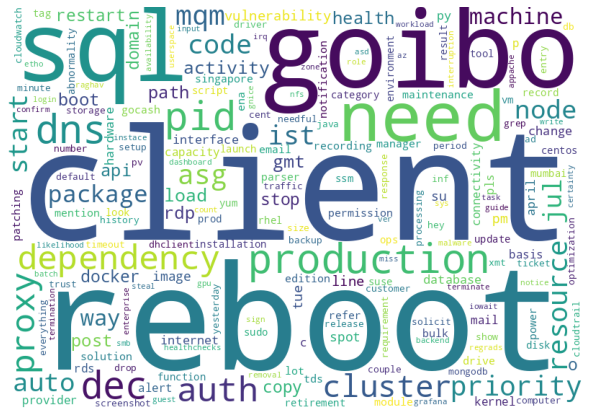

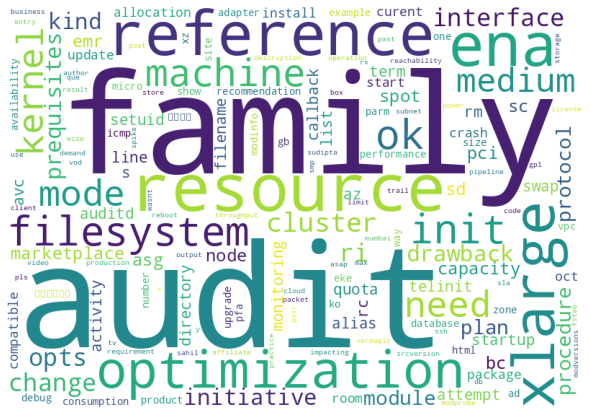

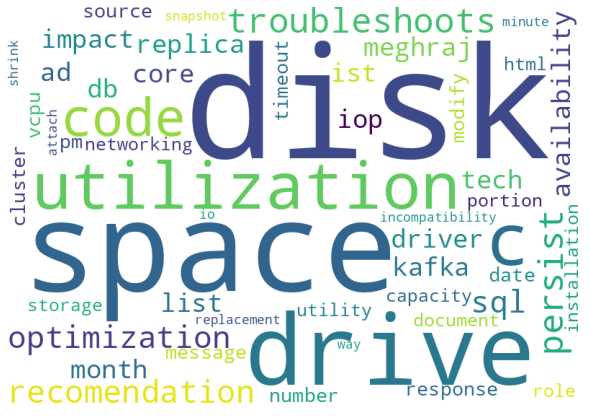

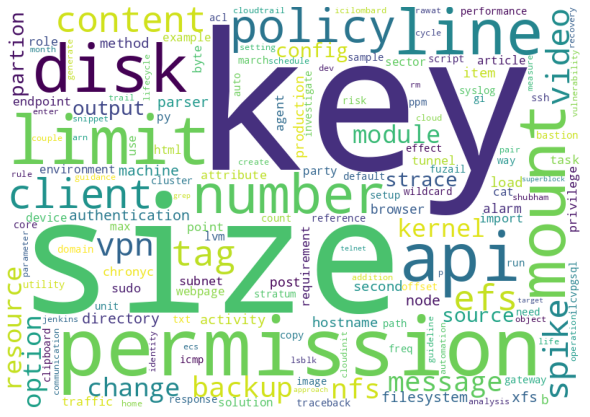

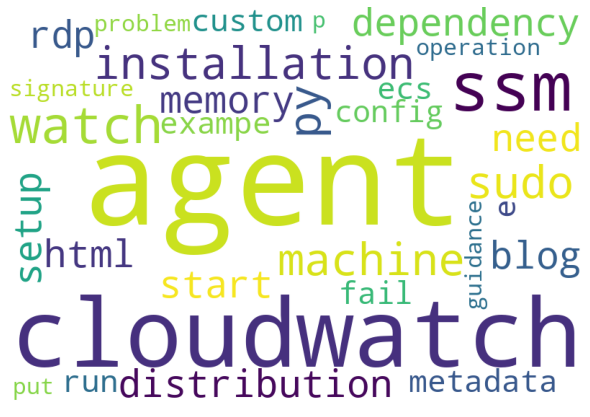

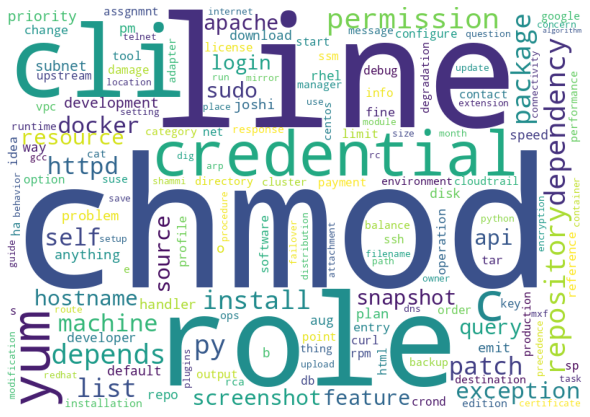

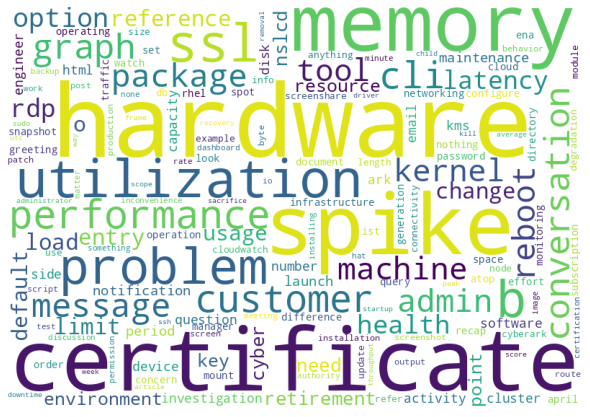

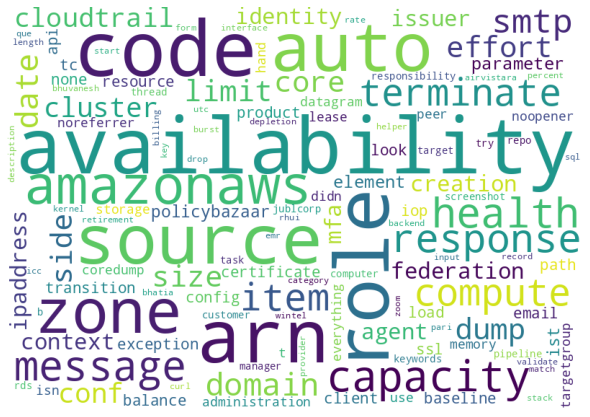

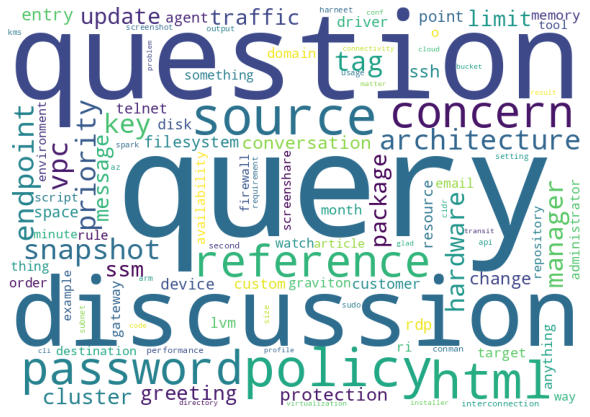

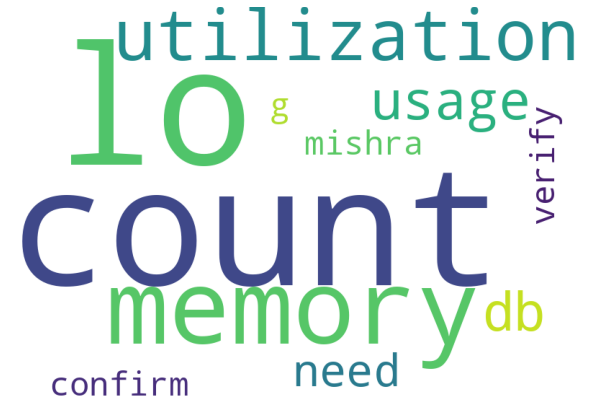

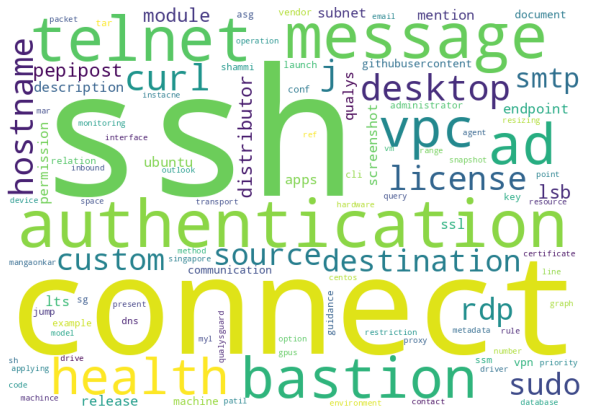

In [186]:
for i in range(tm.k):
    get_wordcloud(tm, token_lists, i)